# Using Regressional Analysis to better understand the ADNI Database:

#### Read the database and select for each person the datapoint with their first MRI Scan:

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

data = pd.read_csv("DATA/ADNI_dataset.csv", low_memory=False) # Need the low_memory or dtypes warning

# The columns that interest us are the sex and age related, the ROIs, as well as the genetic data:
columns_of_interest = ['PTID',
                       'Date',
                       'Age', 
                       'Sex',
                       'APOE4_Alleles',
                       'APOE_Genotype',
                       'Diagnosis_nearest_2.0']
c = list(data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]

columns_of_interest += MRI_columns + genetic_columns

# Need the dropna because some first PTIDs have no MRI
data_of_interest = data[columns_of_interest].dropna(subset=['MUSE_Volume_4'])


unique = data_of_interest.drop_duplicates(subset=['PTID'], keep='first')
print(unique.shape)
unique.head(10)

(1575, 206)


,PTID,Date,Age,Sex,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,...,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,002_S_0295,2006-04-18,84.742466,M,1.0,E3/E4,CN,1873.124153,1586.249283,302.695176,...,0,1,1,1,0,0,0,0,0,1
9,002_S_0413,2006-05-02,76.283562,F,0.0,E3/E3,CN,2131.516933,1505.034469,384.959763,...,1,0,1,1,0,1,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,M,1.0,E3/E4,CN,2366.717680,3157.732947,512.577893,...,2,0,0,0,0,1,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,M,2.0,E4/E4,Dementia,5124.734093,2981.605944,280.547287,...,1,0,0,0,1,1,0,0,0,2
36,002_S_0685,2006-07-06,89.561644,F,0.0,E3/E3,CN,2941.520445,1693.826402,278.437217,...,2,1,1,1,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,F,1.0,E3/E4,MCI,966.095170,1921.643449,356.484899,...,1,0,0,0,1,1,0,0,0,1
57,002_S_0782,2006-08-14,81.575342,M,0.0,E3/E3,MCI,1689.611858,1629.494582,342.773941,...,1,0,0,0,0,2,0,0,0,0
64,002_S_0816,2006-08-30,70.767123,M,2.0,E4/E4,Dementia,1427.160586,1604.163157,375.047405,...,0,0,0,0,0,1,0,0,0,2
69,002_S_0938,2006-10-05,82.167123,F,0.0,E3/E3,Dementia,1931.131939,1136.952611,235.195206,...,0,0,1,1,0,1,0,0,0,0
74,002_S_0954,2006-10-10,69.198630,F,1.0,E3/E4,MCI,707.696352,2621.956978,413.438107,...,2,2,1,1,0,1,0,0,0,1


In [23]:
unique.describe()

,Age,APOE4_Alleles,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,...,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
count,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,...,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000
mean,73.828842,0.572063,1760.721490,1748.099685,354.416530,390.795900,934.624306,982.917557,20201.380908,3177.127800,...,0.949841,0.343492,0.356190,0.361270,0.166984,0.592381,0.175873,0.181587,0.178413,0.568889
std,7.149722,0.666674,776.750403,579.630405,65.339962,71.419641,162.752852,168.428126,2245.917532,489.914071,...,0.711602,0.533009,0.547129,0.551904,0.379831,0.643760,0.406650,0.411142,0.407105,0.666056
min,54.273973,0.000000,279.599289,649.198349,188.787377,219.599442,428.399974,465.599972,14147.216048,1785.595459,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.264384,0.000000,1182.579498,1328.399921,310.077336,345.599979,833.401359,868.801631,18647.398889,2827.617347,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,73.971233,0.000000,1636.881290,1643.708008,351.599979,387.599977,940.672283,984.375000,20007.421875,3114.375000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,78.962329,1.000000,2230.312500,2041.447479,394.799976,432.000811,1041.290250,1093.455436,21692.782898,3443.967374,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,91.306849,2.000000,5464.820847,4804.855004,621.341431,787.197510,1616.396692,1691.996537,31839.946542,5561.985855,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


#### Performing Regressional Analysis to uncover the relation between age, sex and ROIs:

In [124]:
def plot(male_age_data, male_imaging_data, female_age_data, female_imaging_data, name_of_ROI):
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(9,5), dpi=120);
    axes[0].title.set_text("Male Age vs ROI value " + name_of_ROI)
    axes[1].title.set_text("Female Age vs ROI value " + name_of_ROI)
    axes[0].set_xlabel("Age")
    axes[1].set_xlabel("Age")
    axes[0].set_ylabel(name_of_ROI)
    axes[1].set_ylabel(name_of_ROI)
    
    # Plot data and a linear regression model fit.     
    # order=n if change line shape     
    sns.regplot(x=male_age_data, y=male_imaging_data, 
                color = 'blue', 
                scatter=True, 
                marker="+",
                ax = axes[0])
    
    sns.regplot(x=female_age_data, y=female_imaging_data, 
                color = 'red', 
                scatter=True, 
                marker="x",
                ax = axes[1])

    plt.show()

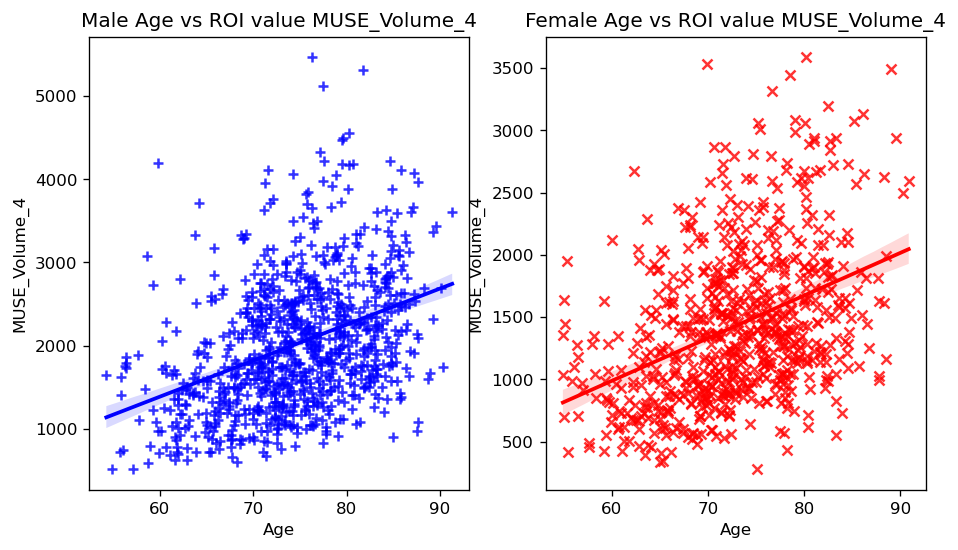

In [130]:
males = unique[unique.Sex == 'M']
females = unique[unique.Sex == 'F']
plot(males.Age.tolist(), males[MRI_columns[0]], 
         females.Age.tolist(), females[MRI_columns[0]], MRI_columns[0])

# for MRI_column in MRI_columns:
#     plot(males.Age.tolist(), males[MRI_column], 
#          females.Age.tolist(), females[MRI_column], MRI_column)